### 1. Q4에서 One-Hot encoding 대신에, Ordinal Encoding을 수행하고 나서 나머지는 동일한 조건으로 학습을 했을 때 Train, Validation Accuracy를 계산해보세요.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

ordinal_encoder = OrdinalEncoder()

train = pd.read_csv("/content/train.csv")

train.Age = train['Age'].fillna(train.Age.median())
train = train.drop(columns='Cabin')
train.Embarked = train.Embarked.fillna('C')

train[['Sex', 'Embarked']] = ordinal_encoder.fit_transform(train[['Sex', 'Embarked']])

drop_cols = ['PassengerId', 'Name', 'Ticket']
train = train.drop(columns = drop_cols)

X = train.drop('Survived', axis = 1)
y = train.Survived

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_val = clf.predict(X_val)

print("Train ACC : %.4f" % accuracy_score(y_train, pred_train))
print("Validation ACC : %.4f" % accuracy_score(y_val, pred_val))

Train ACC : 0.9805
Validation ACC : 0.7803


### 2. Age에 대한 정보를 그냥 중앙값으로 채웠는데, 생각해보니 Age값 자체보다 나이대별로 구분한 정보가 더 도움이 많이 될 것 같다는 판단을 했습니다. 결측치를 채우지 않은 상태에서 나이에 대한 histogram을 그린 뒤에 적절한 구간을 정해서 4개의 서로 다른 나이대로 데이터를 변환하세요.
이 때 구간을 설정하는 것은 histogram을 보고 분석가의 의견에 따라 결정하세요. 그 이유도 함께 서술하세요. 예를 들면, 0 ~ 13세 | 13 ~ 25세 | 25 ~ 40세 | 40세 이상 이렇게 나누었다고 했을 때 원본 데이터는 다음과 같은 코드에 의해 변환될 수 있습니다.

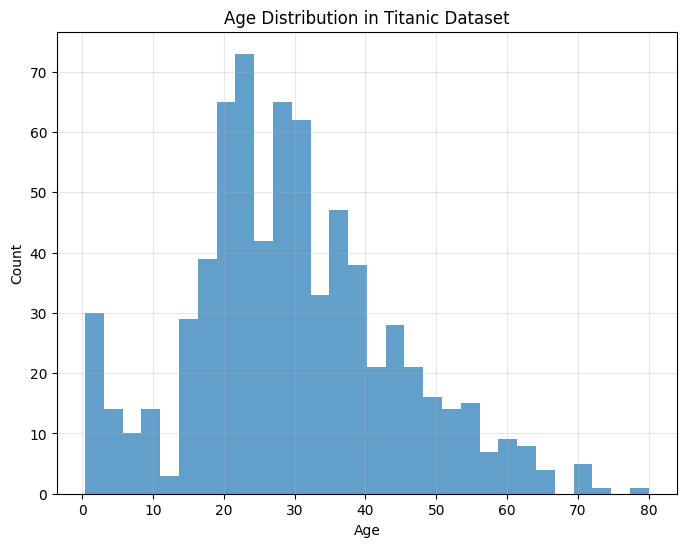

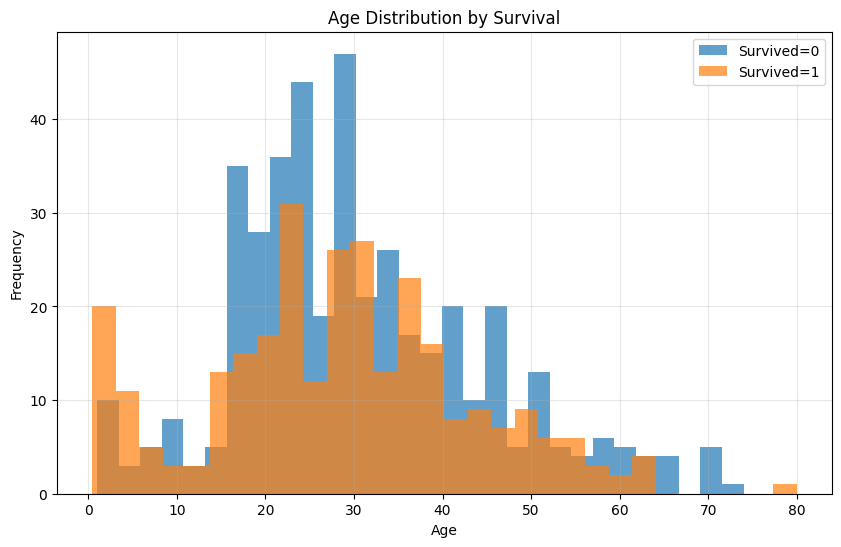

In [2]:
train = pd.read_csv("./train.csv")

# 원본 데이터에서 Age 히스토그램 그리기 (결측치 제외)
plt.figure(figsize=(8, 6))
plt.title('Age Distribution in Titanic Dataset')
plt.xlabel('Age')
plt.ylabel('Count')
train['Age'].dropna().hist(bins=30, alpha=0.7)

plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
for survived in [0, 1]:
    subset = train[train['Survived'] == survived]['Age'].dropna()
    plt.hist(subset, bins=30, alpha=0.7, label=f'Survived={survived}')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution by Survival')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# data['Age'] column에 나이 정보가 있다고 가정
#train.loc[train.Age < 13, 'Age'] = 'low'
#train.loc[(train.Age >= 13) & (train.Age < 25), 'Age'] = 'mid1'
#train.loc[(train.Age >= 25) & (train.Age < 40), 'Age'] = 'mid2'
#train.loc[train.Age >= 40, 'Age'] = 'high'


처음에는 전체 age별 분포를 확인합니다. 일반적으로 20-30대에 피크가 있으며, 어린이와 고령자는 상대적으로 적은 분포를 보인다는 것을 파악할 수 있었습니다. 이후 생존 여부별 나이 분포를 확인합니다. 마찬가지로 비슷한 모습이 나옵니다. 단순히 탑승자 중에 20-30대가 많아서 그런것일수 있기에 다른 기준을 살펴보고자 합니다.

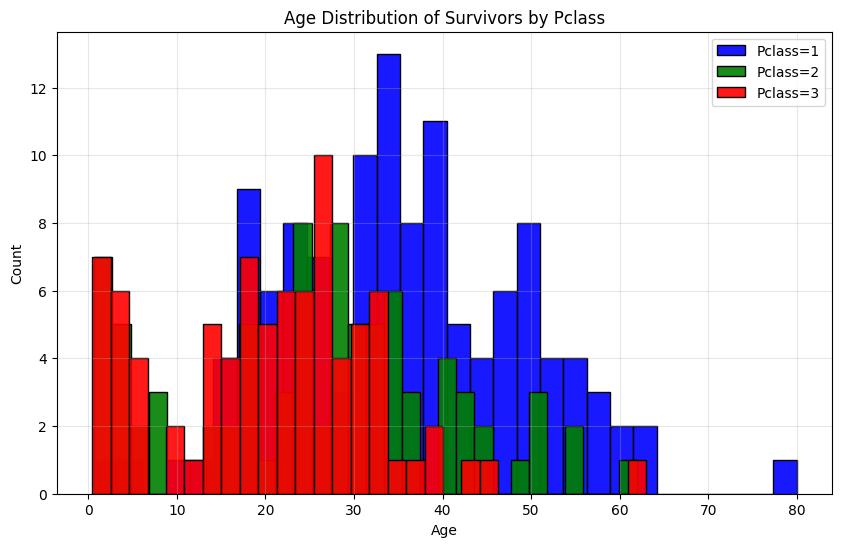

In [5]:
train = pd.read_csv("./train.csv")

# 생존자 데이터 필터링
train_survived = train[train['Survived'] == 1]

# Pclass별 데이터 분리
survived_pclass1 = train_survived[train_survived['Pclass'] == 1]
survived_pclass2 = train_survived[train_survived['Pclass'] == 2]
survived_pclass3 = train_survived[train_survived['Pclass'] == 3]

# 히스토그램 그리기
plt.figure(figsize=(10, 6))
sns.histplot(data=survived_pclass1, x='Age', color='blue', label='Pclass=1', bins=30, alpha=0.9)
sns.histplot(data=survived_pclass2, x='Age', color='green', label='Pclass=2', bins=30, alpha=0.9)
sns.histplot(data=survived_pclass3, x='Age', color='red', label='Pclass=3', bins=30, alpha=0.9)
plt.title('Age Distribution of Survivors by Pclass')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

마찬가지로 50세 이상은 낮은 편입니다. 17세 이하도 낮은 편으로 보입니다. 그 사이는 높습니다. 그렇기에 0 ~ 17, 18 ~ 35, 36 ~ 51, 52 ~ 로 분리해보고자합니다.

In [8]:
train.loc[train.Age <= 17, 'Age'] = 0
train.loc[(train.Age > 17) & (train.Age <= 35), 'Age'] = 1
train.loc[(train.Age > 35) & (train.Age <= 51), 'Age'] = 2
train.loc[train.Age > 51, 'Age'] = 3

###3. RandomForestClassifier를 GridSearchCV 함수를 사용해서 hyper-parameter tuning을 수행하세요. hyper-parameter tuning을 수행할 파라미터는 max_depth, max_feature, n_estimators를 포함하여 5가지 이상 정해보세요. 어떤 값을 사용할지는 제한이 없습니다. 어떤 조합        에서 성능이 가장 잘 나왔는지 정리해보세요.

In [9]:
from sklearn.model_selection import GridSearchCV
import time

train = pd.read_csv("./train.csv")

train['Age'] = train['Age'].fillna(train['Age'].median())

train.loc[train.Age <= 17, 'Age'] = 0
train.loc[(train.Age > 17) & (train.Age <= 35), 'Age'] = 1
train.loc[(train.Age > 35) & (train.Age <= 51), 'Age'] = 2
train.loc[train.Age > 51, 'Age'] = 3



train = train.drop(columns='Cabin', axis = 1)
train.Embarked = train['Embarked'].fillna('C')
train[['Sex', 'Embarked']] = ordinal_encoder.fit_transform(train[['Sex', 'Embarked']])
drop_cols = ['PassengerId', 'Name', 'Ticket']
train = train.drop(columns = drop_cols)

X = train.drop('Survived', axis=1)
y = train['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# 5가지 이상 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [50, 100, 200, 300],           # 트리 개수
    'max_depth': [3, 5, 7, 10, 15, None],         # 최대 깊이
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.8, 1.0],  # 특성 선택 비율
    'min_samples_split': [2, 5, 10, 20],          # 분할 최소 샘플
    'min_samples_leaf': [1, 2, 4, 8],             # 리프 최소 샘플
    'bootstrap': [True, False],                     # 부트스트랩 여부
    'class_weight': [None, 'balanced']             # 클래스 가중치
}

# 시간 단축을 위한 작은 그리드 (먼저 이걸로 테스트)
small_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10, None],
    'max_features': ['sqrt', 0.5, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print("GridSearchCV 시작... (약 5-10분 소요)")
start_time = time.time()

# GridSearchCV 실행
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    small_param_grid,
    cv=5,                    # 5-fold 교차검증
    scoring='accuracy',      # 평가지표
    n_jobs=-1,              # 모든 CPU 사용
    verbose=2               # 진행상황 출력
)

grid_search.fit(X_train, y_train)

end_time = time.time()
print(f"소요시간: {end_time - start_time:.2f}초")

# 최적 파라미터 출력
print("\n=== 최적 하이퍼파라미터 ===")
best_params = grid_search.best_params_
for param, value in best_params.items():
    print(f"{param}: {value}")

print(f"\n최고 교차검증 점수: {grid_search.best_score_:.4f}")

# 최적 모델로 성능 평가
best_model = grid_search.best_estimator_
pred_train_best = best_model.predict(X_train)
pred_val_best = best_model.predict(X_val)

print("\n=== 튜닝 후 성능 ===")
print(f"Train ACC: {accuracy_score(y_train, pred_train_best):.4f}")
print(f"Validation ACC: {accuracy_score(y_val, pred_val_best):.4f}")

# 상위 5개 조합도 확인해보자
print("\n=== 상위 5개 조합 ===")
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['mean_test_score', 'params']]
for i, (idx, row) in enumerate(top_5.iterrows()):
    print(f"{i+1}위: 점수 {row['mean_test_score']:.4f}, 파라미터: {row['params']}")


GridSearchCV 시작... (약 5-10분 소요)
Fitting 5 folds for each of 144 candidates, totalling 720 fits
소요시간: 103.79초

=== 최적 하이퍼파라미터 ===
max_depth: 10
max_features: 1.0
min_samples_leaf: 2
min_samples_split: 5
n_estimators: 200

최고 교차검증 점수: 0.8279

=== 튜닝 후 성능 ===
Train ACC: 0.8982
Validation ACC: 0.8296

=== 상위 5개 조합 ===
1위: 점수 0.8279, 파라미터: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
2위: 점수 0.8249, 파라미터: {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
3위: 점수 0.8249, 파라미터: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
4위: 점수 0.8233, 파라미터: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
5위: 점수 0.8233, 파라미터: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


n_estimators: 200, max_depth: 10, max_features: 1.0, min_samples_split: 5, min_samples_leaf: 2일 때 Train ACC는 89.82%, Validation ACC는 82.96%로 제일 좋았습니다.